In [2]:
import pandas as pd
import numpy as np
import pickle

from torch.autograd import Variable
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader


import torch.utils.data as data_utils
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from scipy import stats

import matplotlib.pyplot as plt
import seaborn as sns
from pylab import rcParams

from sklearn.metrics import (confusion_matrix, precision_recall_curve, auc,
                             roc_curve, recall_score, classification_report, f1_score,
                             precision_recall_fscore_support)

sns.set(style='whitegrid', palette='muted', font_scale=1.5)

rcParams['figure.figsize'] = 14, 8

RANDOM_SEED = 42
LABELS = ["Normal", "Fraud"]

In [3]:
# Import Data
df = pd.read_csv('creditcard.csv')

# Get Num samples for each class
fraudsDF = df[df.Class == 1]
normalDF = df[df.Class == 0]

print("Number of Features: ", fraudsDF.shape[1])
print("Number of Fraudulent Transactions: ",fraudsDF.shape[0])
print("Number of Normal Transactions",normalDF.shape[0])

Number of Features:  31
Number of Fraudulent Transactions:  492
Number of Normal Transactions 284315


In [4]:
df.head(5)

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


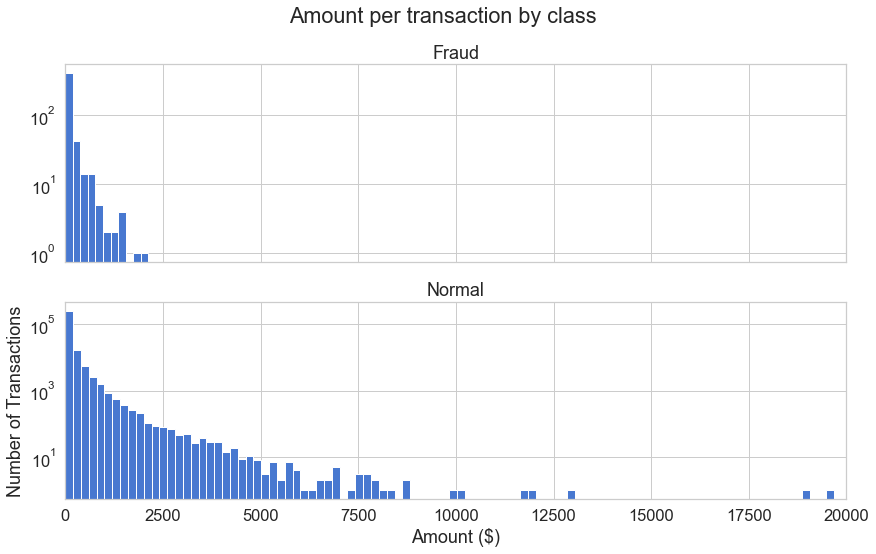

In [7]:
# Cost Trends
# Plot amount per transaction for Fraud and Normal Transactions

fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
fig.suptitle('Amount per transaction by class')

ax1.hist(fraudsDF.Amount, bins = round(max(fraudsDF.Amount)/200))
ax1.set_title('Fraud')

ax2.hist(normalDF.Amount, bins = round(max(normalDF.Amount)/200))
ax2.set_title('Normal')

plt.xlabel('Amount ($)')
plt.ylabel('Number of Transactions')
plt.xlim((0, 20000))
ax1.set_yscale('log')
ax2.set_yscale('log')
# plt.yscale('log')
plt.show();

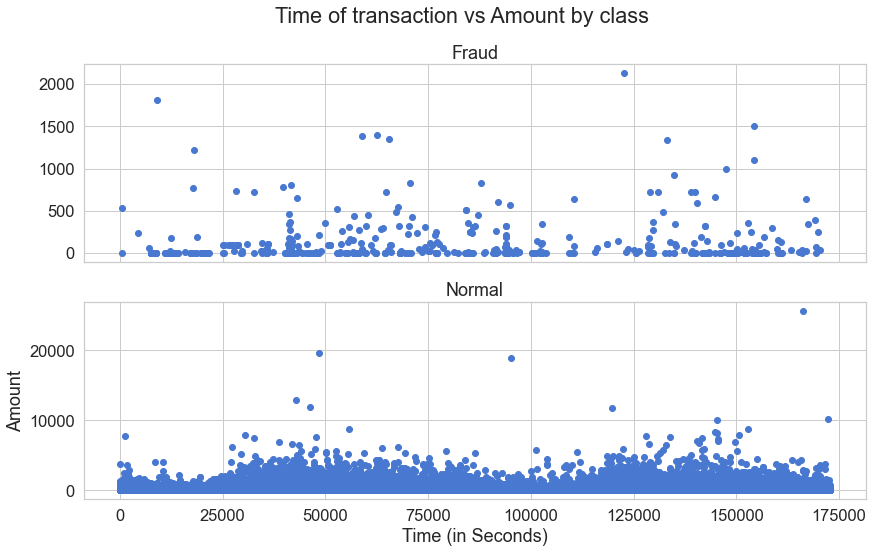

In [55]:
# Time Trends
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
fig.suptitle('Time of transaction vs Amount by class')

ax1.scatter(fraudsDF.Time, fraudsDF.Amount)
ax1.set_title('Fraud')

ax2.scatter(normalDF.Time, normalDF.Amount)
ax2.set_title('Normal')

plt.xlabel('Time (in Seconds)')
plt.ylabel('Amount')
plt.show()

In [78]:
transactionData = df.drop(['Time'], axis=1)
transactionData['Amount'] = StandardScaler().fit_transform(transactionData['Amount'].values.reshape(-1, 1))

In [79]:
# Split Dataset 80% training, 20% testing
X_train, X_test = train_test_split(transactionData, test_size=0.2, random_state=20)
X_train = X_train[X_train.Class == 0]
X_train = X_train.drop(['Class'], axis=1)
#print(type(X_train))
y_test = X_test['Class']
X_test = X_test.drop(['Class'], axis=1)

X_train = X_train.values
#print(type(X_train))
X_test = X_test.values
y_test = y_test.values
print(y_test.size)

56962


In [80]:
class Autoencoder(nn.Module):
    '''
    We are building an autoencoder with 4 connected layers with 14, 7, 7, 29 Neurons (not sure why)
    First two layers act as encoder
    Last two layers act as decoder
    last layer of 29 neurons corresponds to number of features
    '''
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(29, 14),
            nn.Tanh(),
            nn.Linear(14, 7),
            nn.LeakyReLU(),
            )
        
        self.decoder = nn.Sequential(
           nn.Linear(7, 7),
           nn.Tanh(),
           nn.Linear(7, 29),
           nn.LeakyReLU()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [81]:
model = Autoencoder().double().cpu()

In [82]:
num_epochs = 100
minibatch_size = 32
learning_rate = 1e-3

train_loader = data_utils.DataLoader(X_train, batch_size=minibatch_size, shuffle=True)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(
model.parameters(), lr=learning_rate, weight_decay=10e-05)

history = {}
history['train_loss'] = []
history['test_loss'] = []

In [83]:
#test = data_utils.TensorDataset(torch.from_numpy(X_test).double(),torch.from_numpy(y_test).double())
#test_loader = data_utils.DataLoader(test, batch_size=minibatch_size, shuffle=True)
# test_loader = data_utils.DataLoader(X_test, batch_size=1, shuffle=False)

In [84]:
for epoch in range(num_epochs):
    h = np.array([])
    for data in train_loader:
        #print(type(data))
        #data = Variable(data).cpu()
        #print(type(data))
        # ===================forward=====================
        output = model(data)
        loss = criterion(output, data)
        h = np.append(h, loss.item())
        
        # ===================backward====================
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    # ===================log========================
    mean_loss = np.mean(h)
    print('epoch [{}/{}], loss:{:.4f}'
          .format(epoch + 1, num_epochs, mean_loss))
    history['train_loss'].append(mean_loss)
    

torch.save(model.state_dict(), './credit_card_model.pth')

epoch [1/100], loss:0.7995
epoch [2/100], loss:0.7360
epoch [3/100], loss:0.7230
epoch [4/100], loss:0.7174
epoch [5/100], loss:0.7135
epoch [6/100], loss:0.7113
epoch [7/100], loss:0.7096
epoch [8/100], loss:0.7088
epoch [9/100], loss:0.7078
epoch [10/100], loss:0.7069
epoch [11/100], loss:0.7066
epoch [12/100], loss:0.7063
epoch [13/100], loss:0.7060
epoch [14/100], loss:0.7060
epoch [15/100], loss:0.7057
epoch [16/100], loss:0.7056
epoch [17/100], loss:0.7054
epoch [18/100], loss:0.7051
epoch [19/100], loss:0.7049
epoch [20/100], loss:0.7049
epoch [21/100], loss:0.7047
epoch [22/100], loss:0.7045
epoch [23/100], loss:0.7046
epoch [24/100], loss:0.7044
epoch [25/100], loss:0.7043
epoch [26/100], loss:0.7041
epoch [27/100], loss:0.7040
epoch [28/100], loss:0.7041
epoch [29/100], loss:0.7041
epoch [30/100], loss:0.7037
epoch [31/100], loss:0.7035
epoch [32/100], loss:0.7026
epoch [33/100], loss:0.7020
epoch [34/100], loss:0.7016
epoch [35/100], loss:0.7013
epoch [36/100], loss:0.7008
e